# Gait Cycle defined by bbox

This file used to compare the splitted gait cycel index with different method.
Here have 3 method to split the gait cycle:

1. Using the bbox of the human body width (max width) to split the gait cycle.
2. Using the foot keypoints to split the gait cycle.
3. Mix the bbox and foot keypoints to split the gait cycle.

For the results metrics, we use Euclidean Distance to calculate the difference between the gait cycle index with different method.


In [1]:
import json

# video_name = "LCS_HipOA/20170731_LCS_lat_V1-0001.json"
# video_name = "ASD/20160120_ASD_lat__V1-0001.json"
video_name = "DHS/20160927_DHS_lat_V1-0001.json"
# video_name = "LCS_HipOA/20180806_2_HipOA_lat_V1-0001.json"

# mix method
with open("/workspace/data/segmentation_dataset_512/json_mix/" + video_name, "r") as f:
    mix_method = json.load(f)

# bbox method
with open("/workspace/data/segmentation_dataset_512/json_bbox/" + video_name) as f:
    bbox_method = json.load(f)

# pose method
with open("/workspace/data/segmentation_dataset_512/json_pose/" + video_name) as f:
    pose_method = json.load(f)


print(f'mix method: {mix_method["gait_cycle_index"]}')
print(f'bbox method: {bbox_method["gait_cycle_index_bbox"]}')
print(f'pose method: {pose_method["gait_cycle_index"]}')

mix method: [0, 15, 30, 46, 62, 79, 94, 111, 120]
bbox method: [0, 15, 30, 46, 62, 79, 94, 111, 120]
pose method: [0, 14, 30, 46, 62, 79, 95, 111]


In [2]:
mix_method["video_path"]

'/workspace/data/segmentation_dataset_512/fold0/train/ASD_not/20160927_DHS_lat_V1-0001.mp4'

In [3]:
# Python code to find Euclidean distance
# using dot()

import numpy as np

# initializing points in
# numpy arrays
bbox = np.array((0, 50, 80, 138, 149, 0, 221))
pose = np.array((18, 29, 74, 85, 108, 136, 147, 168, 198, 209))
proposed = np.array((18, 29, 74, 85, 108, 136, 168, 198, 209))
ground_truth = np.array((18, 0, 50, 85, 108, 140, 168, 198, 0))

# subtracting vector
temp = proposed - ground_truth

# doing dot product
# for finding
# sum of the squares
sum_sq = np.dot(temp.T, temp)

# Doing squareroot and
# printing Euclidean distance
print(np.sqrt(sum_sq) / len(pose))

21.240056497100003


# Frame for annotation


In [4]:
from torchvision.io import read_video
import matplotlib.pyplot as plt

# load video
video_path = mix_method["video_path"]
vframes, *_ = read_video(video_path, pts_unit="sec", output_format="THWC")
vframes.shape

torch.Size([120, 512, 512, 3])

In [5]:
# for frame in range(vframes.shape[0]):
#     plt.imshow(vframes[frame])
#     plt.title(f'frame: {frame}')
#     plt.show()

# Compare the SSIM of different phase


In [6]:
from skimage.metrics import structural_similarity as ssim
from torchvision.transforms.functional import crop, rgb_to_grayscale, resize, pad

In [7]:
gait_cycle_index = mix_method["gait_cycle_index"]

stance_phase = gait_cycle_index[1:3]
swing_phase = gait_cycle_index[2:4]

stance_phase, swing_phase


([15, 30], [30, 46])

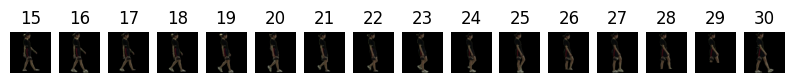

In [8]:
# stance phase 
# 创建子图
fig, axes = plt.subplots(1, int(stance_phase[1] - stance_phase[0]+1), figsize=(10,1))

# 读取并显示每张图像
for num, i in enumerate(range(stance_phase[0], stance_phase[1]+1, 1)):
	img = vframes[i]
	ax = axes[num]
	ax.imshow(img)
	ax.axis('off')
	ax.set_title(f'{i}')

fig.show()

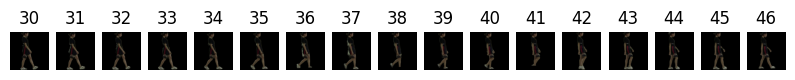

In [9]:
# stance phase 
# 创建子图
fig, axes = plt.subplots(1, int(swing_phase[1] - swing_phase[0]+1), figsize=(10,1))

# 读取并显示每张图像
for num, i in enumerate(range(swing_phase[0], swing_phase[1]+1, 1)):
	img = vframes[i]
	ax = axes[num]
	ax.imshow(img)
	ax.axis('off')
	ax.set_title(f'{i}')

fig.show()

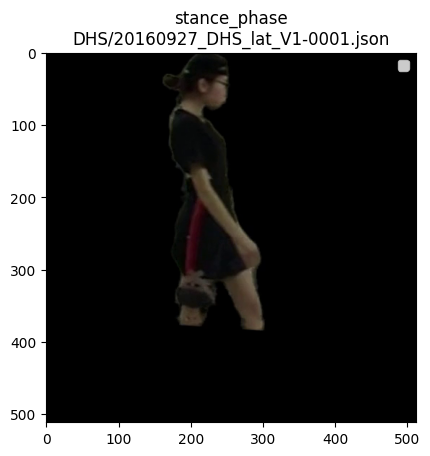

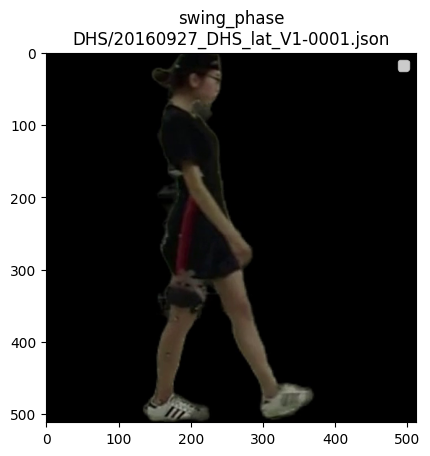

In [10]:
import matplotlib.animation as animation 

def draw_gif(phase, str_phase):

    # 创建一个图形和轴
    fig, ax = plt.subplots()

    # 创建一个函数来更新图形内容
    def update(frame):
        ax.clear()  # 清除轴	;
        img = vframes[frame]  # 读取图像
        ax.legend([f'{frame}'])
        ax.imshow(img)  # 显示图像
        ax.set_title(f'{str_phase}\n{video_name}')

    # 创建动画
    ani = animation.FuncAnimation(fig, update, frames=range(phase[0], phase[1]), interval=1)

    # 保存动画为 GIF 文件
    name = video_name.split('/')[-1].split('.')[0]
    ani.save(f'{name}_{str_phase}_animation.gif', writer='pillow')  # 通过pillow写入GIF

draw_gif(stance_phase, 'stance_phase')
draw_gif(swing_phase, 'swing_phase')

In [11]:
# calc mean ssim cross all frames
ans = []

for i in range(vframes.size()[0]-1):
    
	first_gray = rgb_to_grayscale(vframes[i].permute(2,0,1))
	second_gray = rgb_to_grayscale(vframes[i+1].permute(2,0,1))

	first_gray = resize(first_gray, (256, 256)).squeeze()
	second_gray = resize(second_gray, (256, 256)).squeeze()

	score = ssim(first_gray.numpy(), second_gray.numpy())
	ans.append(score)

np.mean(ans)



/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


0.8555572014744651

In [12]:
# calc SSIM 

def calc_ssim(phase):
    ans = []
    for i in range(phase[0], phase[1], 1):

        first_gray = rgb_to_grayscale(vframes[i].permute(2,0,1))
        second_gray = rgb_to_grayscale(vframes[i+1].permute(2,0,1))

        first_gray = resize(first_gray, (256, 256)).squeeze()
        second_gray = resize(second_gray, (256, 256)).squeeze()

        score = ssim(first_gray.numpy(), second_gray.numpy())
        ans.append(score)

    return ans

res = calc_ssim(stance_phase)
res

[0.8524076451740624,
 0.8966504635728423,
 0.8409383897440951,
 0.8779003869051683,
 0.8839590632642582,
 0.8845634909779561,
 0.8941395345675063,
 0.8716399606767162,
 0.8730698361255382,
 0.8659873361377165,
 0.8534293838844238,
 0.8356690307038079,
 0.8457375792153452,
 0.9241393663866734,
 0.805269641136759]

In [13]:
stance_ssim = calc_ssim(stance_phase)
swing_ssim = calc_ssim(swing_phase)

print(video_name)
print(f'overall frames: {np.mean(ans)}')
print(f'stance phase: {np.mean(stance_ssim)}')
print(f'swing phase: {np.mean(swing_ssim)}')

DHS/20160927_DHS_lat_V1-0001.json
overall frames: 0.8555572014744651
stance phase: 0.8670334072315247
swing phase: 0.8558171537116805


# Gait Cycle defined method 
explain the method of the gait cycle defined

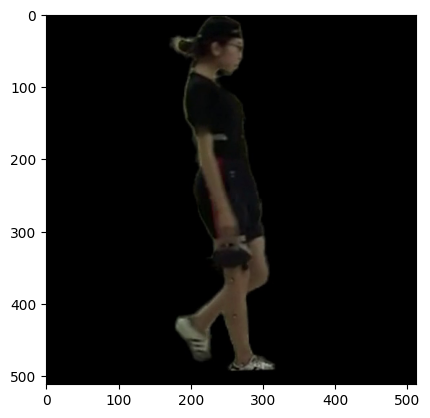

In [14]:
plt.imshow(vframes[22])